<a href="https://colab.research.google.com/github/dvircohen0/GAN/blob/main/SRGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files 
files.upload()

In [23]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [25]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:06<00:00, 215MB/s]
100% 1.33G/1.33G [00:07<00:00, 202MB/s]


In [ ]:
!unzip "/content/celeba-dataset.zip"

In [2]:
from __future__ import print_function
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable
from torchvision.utils import save_image

In [3]:
if not os.path.exists("/content/images"):
  os.mkdir("/content/images")
dataroot ="/content/img_align_celeba"
workers = 2
batch_size = 10
image_size_HR = 64
image_size_LR = 32
nc = 3
nz = 100
ngf = 32
ndf = 32
num_epochs = 3
lr = 0.0002
beta1 = 0.5
ngpu = 1
sample_interval = 400

In [ ]:
dataset_HR =dset.ImageFolder(root=dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size_HR),
                              transforms.CenterCrop(image_size_HR),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))]))

dataset_LR =dset.ImageFolder(root=dataroot,
                          transform = transforms.Compose([
                              transforms.Resize(image_size_LR),
                              transforms.CenterCrop(image_size_LR),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))]))

dataloader_HR = torch.utils.data.DataLoader(dataset_HR, batch_size=batch_size,
                                         shuffle = False, num_workers=workers, drop_last=True)

dataloader_LR = torch.utils.data.DataLoader(dataset_LR, batch_size=batch_size,
                                         shuffle = False, num_workers=workers, drop_last=True)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

real_batch = next(iter(dataloader_HR))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("HR_Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

real_batch = next(iter(dataloader_LR))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("LR_Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("conv") != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [8]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(3, 32 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32 * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32 * 8, 32 * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32 * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32 * 4, 32 * 2, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32 * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32 * 2, 32, 3, 1, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(32, nc, 3, 1, 1, bias = False),
            nn.Tanh()
            )
        
    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
netG.apply(weights_init)
print(netG)  


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): Ta

In [32]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid() 
            )
    def forward(self, input):
        return self.main(input)

netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)  

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [33]:
loss = nn.MSELoss()

real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
Tensor = torch.cuda.FloatTensor

for epoch in range(num_epochs):
  for i , ((imgs_HR,_),(imgs_LR,_)) in enumerate(zip(dataloader_HR, dataloader_LR)):

    batch_size_HR = imgs_HR.shape[0]
    batch_size_LR = imgs_LR.shape[0]

    valid = Variable(Tensor(batch_size_HR, 1).fill_(1.0), requires_grad=False )
    fake = Variable(Tensor(batch_size_LR, 1).fill_(0.0), requires_grad=False )

    imgs_HR = Variable(imgs_HR.type(Tensor).expand(imgs_HR.size(0), 3, image_size_HR, image_size_HR))
    imgs_LR = Variable(imgs_LR.type(Tensor).expand(imgs_LR.size(0), 3, image_size_LR, image_size_LR))

    # Train Generator
    optimizerG.zero_grad

    gen_imgs = netG(imgs_LR)
    validity = netD(gen_imgs)

    g_loss = (loss(gen_imgs, imgs_HR))
    g_loss.backward()
    optimizerG.step()

    # Train Discriminator
    optimizerD.zero_grad

    validity_real = netD(imgs_HR)
    
    validity_fake = netD(gen_imgs.detach())
    #print(validity_real.shape, valid.shape)

    d_loss = (loss(validity_real, valid) + loss(validity_fake,fake)) / 2
    d_loss.backward()
    optimizerD.step()
    
    #print(d_loss.data)

    batch_done = epoch * len(dataloader_HR) + i
    if batch_done % sample_interval == 0:
      gen_imgs = torch.cat((imgs_HR.data, gen_imgs.data), 0)
      save_image(gen_imgs, "images/%d.png" % batch_done, nrow=10, normalize=True)
      print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
      % (epoch, num_epochs, i , len(dataloader_HR), d_loss.item(), g_loss.item()))



In [104]:
torch.save(netG.state_dict(), "/content/SRGAN.pt")

In [ ]:
!zip -r /content/SRGAN_images.zip /content/images
from google.colab import files
files.download("/content/SRGAN_images.zip")
files.download("/content/SRGAN.pt")

In [ ]:
import torch
SRGAN = Generator()
SRGAN.load_state_dict(torch.load("/content/SRGAN.pt"))

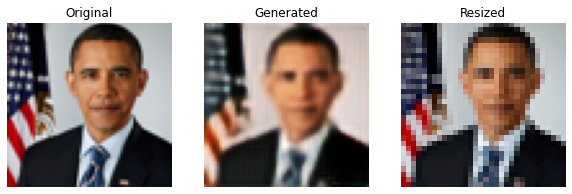

In [65]:
from PIL import Image
import requests
from io import BytesIO
url ="https://www.biography.com/.image/t_share/MTE4MDAzNDEwNzg5ODI4MTEw/barack-obama-12782369-1-402.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
transform = transforms.Compose([
                              transforms.Resize((32,32)),
                              #transforms.CenterCrop(32),
                              transforms.ToTensor(),
                              transforms.Normalize((0.5, 0.5,0.5), (0.5,0.5,0.5))])

tensor_img = transform(img) 
new_tensor = tensor_img.repeat(10, 1, 1, 1)
generated = SRGAN(new_tensor)
save_image(generated.data[3], "test.png", nrow=1, normalize=True)
original_resized = img.resize((64, 64))
small_resized = img.resize((32, 32))
img = Image.open("/content/test.png")


f, axarr = plt.subplots(1,3,figsize=(10,10))
axarr[0].imshow(original_resized)
axarr[0].title.set_text('Original')
axarr[0].axis('off')
axarr[1].imshow(img)
axarr[1].title.set_text('Generated')
axarr[1].axis('off')
axarr[2].imshow(small_resized)
axarr[2].title.set_text('Resized')
axarr[2].axis('off')
plt.show()